### Experiment 0


The objective with this experiment is to test the pipeline devloped.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from time import time
from tqdm import tqdm
import datetime
import os
import numpy as np
import tensorflow as tf
import keras
import sklearn.model_selection as sk
import copy
from PIL import Image as IM
from keras.callbacks import TensorBoard
import cv2
import json
import pathlib
from glob import glob

Using TensorFlow backend.


In [2]:
## import helpers
from helpers import data_loaders as dls
from helpers import pointcloud as pc
from helpers.viz import plot, plot_history
from helpers.logger import Logger

In [3]:
import lodnn

In [4]:
PATH = '../' # path of the repo.
_NAME = 'experiment0' # name of experiment
!ls $PATH

dataset  nbs  README.md  TODO


In [5]:
# It is better to create a folder with runid in the experiment folder
_EXP, _LOG, _TMP, _MODEL, _RES = dls.create_dir_struct(PATH, _NAME)
logger = Logger('EXP0', _LOG + 'experiment0.log')
logger.debug('Logger EXP0 int')
!ls $_EXP

log  result  tmp


In [6]:
# get dataset
train_set, valid_set, test_set = dls.get_dataset(PATH, is_training=True)

In [7]:
z_vals = dls.process_pc(train_set["pc"] + valid_set["pc"], lambda x: x[:, 2])
z_vals = np.concatenate(z_vals)
HEIGHT_MIN, HEIGHT_MAX = np.min(z_vals), np.max(z_vals)
print("Height ranges from {} to {}".format(HEIGHT_MIN, HEIGHT_MAX))
del z_vals

Height ranges from -30.21500015258789 to 2.9130001068115234


In [8]:
def preprocess(points):
    global HEIGHT_MIN, HEIGHT_MAX
    points = pc.filter_points(points, side_range=(-10, 10), fwd_range=(6, 46))
    z = points[:, 2]
    z_min, z_max = HEIGHT_MIN, HEIGHT_MAX
    z = (z - z_min)/(z_max - z_min)
    points[:, 2] = z
    return points

In [9]:
f_count = dls.process_pc(train_set["pc"] + valid_set["pc"],
                       lambda x: lodnn.get_features(preprocess(x))[:,:,0])

f_count = np.concatenate(f_count)
COUNT_MIN, COUNT_MAX = 0, np.max(f_count)
print("Count varies from {} to {}".format(COUNT_MIN, COUNT_MAX))
del f_count

Count varies from 0 to 122.0


In [10]:
def _get_features(points):
    global COUNT_MAX
    f = lodnn.get_features(preprocess(points))
    f[:, :, 0] = f[:, :, 0] / COUNT_MAX
    return f

In [11]:
f_train = dls.process_pc(train_set["pc"][0:5], lambda x: _get_features(x))
f_valid = dls.process_pc(valid_set["pc"][0:2], lambda x: _get_features(x))
f_test = dls.process_pc(test_set["pc"][0:2], lambda x: _get_features(x))

In [12]:
def kitti_gt(img):
    road = img[:, :, 0] / 255 # Road is encoded as 255 in the B plane
    non_road = 1 - road # TODO: can we do this in training time?
    return np.dstack([road, non_road])

In [13]:
gt_train = dls.process_img(train_set["gt_bev"][0:5], func=lambda x: kitti_gt(x))
gt_valid = dls.process_img(valid_set["gt_bev"][0:2], func=lambda x: kitti_gt(x))
gt_test = dls.process_img(train_set["gt_bev"][0:2], func=lambda x: kitti_gt(x))

In [ ]:
_ = plot([[f_train[0][:,:,0], f_train[1][:,:,0],  f_train[2][:,:,0]],
      [f_train[0][:,:,1], f_train[1][:,:,1],  f_train[2][:,:,1]],
      [gt_train[0][:,:,0], gt_train[1][:,:,0], gt_train[1][:,:,0]]
     ])

In [ ]:
# Let the training begin

In [14]:
model = lodnn.get_model()
# model.summary()

In [15]:
def get_unique_id():
    return datetime.datetime.today().strftime('%Y_%m_%d_%H_%M')

In [16]:
run_id = get_unique_id()
run_id

'2019_07_08_07_30'

In [18]:
# training func - define a training func to do training
# unique identifier
# callbacks
    # save the best model
    # model saving - save models after specific epochs
    # tensorboard - save the history for analysis
    # 

In [19]:
# !ls $_EXP

In [20]:
def get_basic_callbacks(exp_path, run_id):
    # tensorboard
    # to visualise `tensorboard --logdir="./path_to_log_dir" --port 6006`
    log_path = "{}/log/{}/".format(exp_path, run_id)
    os.makedirs(log_path, exist_ok=True)
    tensorboard = TensorBoard(log_dir="{}/{}".format(log_path, time()))
    # save best model
    best_model_path = "{}/result/model/{}/best_model.h5".format(exp_path, run_id) #? .hd5
    os.makedirs(os.path.dirname(best_model_path), exist_ok=True)
    save_the_best = keras.callbacks.ModelCheckpoint(filepath=best_model_path,
                                                    verbose=1, save_best_only=True)
    # save models after few epochs
    epoch_save_path = "{}/result/model/{}/*.h5".format(exp_path, run_id)
    save_after_epoch = keras.callbacks.ModelCheckpoint(filepath=epoch_save_path.replace('*', 'e{epoch:02d}-val_acc{val_acc:.2f}'),
                                                       monitor='val_acc', verbose=1, period = 1)
    return [tensorboard, save_the_best, save_after_epoch]

In [21]:
callbacks = get_basic_callbacks(_EXP, run_id)

In [ ]:
# Add more callbacks
# early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
# reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.000001)
# callbacks = callbacks + [early_stopping, reduce_lr]

In [ ]:
# model.get_config()

In [22]:
training_config = {
    "loss_function" : "binary_crossentropy",
    "learning_rate" : 1e-4,
    "batch_size"    : 1,
    "epochs"        : 3,
    "optimizer"     : "keras.optimizers.Adam"
}

In [23]:
optimizer = eval(training_config["optimizer"])(lr=training_config["learning_rate"])
optimizer

In [24]:
model.compile(loss=training_config["loss_function"],
              optimizer=optimizer,
              metrics=['accuracy'])

In [25]:
# model.fit(X_train, Y_train, validation_data=(X_test, Y_test))
# TODO: add fit_generator
m_history = model.fit(x=np.array(f_train),
                      y=np.array(gt_train),
                      batch_size=training_config["batch_size"],
                      epochs=training_config["epochs"],
                      verbose=1,
                      callbacks=callbacks,
                      validation_data=(np.array(f_valid), np.array(gt_valid))) 

Train on 5 samples, validate on 2 samples
Epoch 1/3
4/5 [=======================>......] - ETA: 6s - loss: 0.6918 - acc: 0.5210 Epoch 00001: val_loss improved from inf to 0.68080, saving model to ..//nbs/output/experiment0/result/model/2019_07_08_07_30/best_model.h5
Epoch 00001: saving model to ..//nbs/output/experiment0/result/model/2019_07_08_07_30/e01-val_acc0.67.h5
5/5 [==============================] - 35s 7s/step - loss: 0.6887 - acc: 0.5448 - val_loss: 0.6808 - val_acc: 0.6667
Epoch 2/3
4/5 [=======================>......] - ETA: 6s - loss: 0.6688 - acc: 0.6449 Epoch 00002: val_loss improved from 0.68080 to 0.65253, saving model to ..//nbs/output/experiment0/result/model/2019_07_08_07_30/best_model.h5
Epoch 00002: saving model to ..//nbs/output/experiment0/result/model/2019_07_08_07_30/e02-val_acc0.68.h5
5/5 [==============================] - 34s 7s/step - loss: 0.6652 - acc: 0.6686 - val_loss: 0.6525 - val_acc: 0.6756
Epoch 3/3
4/5 [=======================>......] - ETA: 6s - l

In [26]:
model.save("{}/result/model/{}/final_model.h5".format(_EXP, run_id))

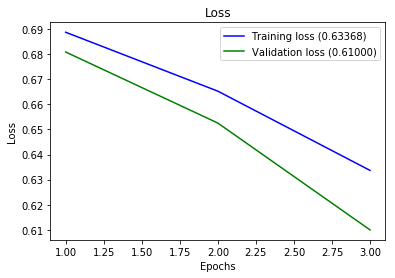

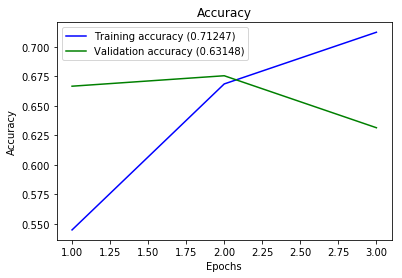

In [48]:
plot_history(m_history)
# TODO: Save these plots to result/output

1/1 [==============================] - 2s 2s/step


[[<matplotlib.axes._subplots.AxesSubplot at 0x7fac40b17828>]]

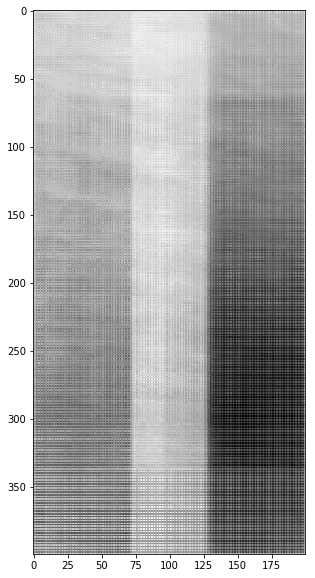

In [49]:
f_pc_test = dls.process_pc(test_set["pc"][0:1], lambda x: _get_features(x))
f_pc_test = np.expand_dims(f_pc_test[0], axis=0)
res_test = model.predict(f_pc_test, verbose=1).squeeze()
plot([[res_test[:, : , 0]]])

In [41]:
def get_prediction(model, points):
    '''
    Get prediction for a given model and point cloud.
    '''
    f = _get_features(points)
    f = np.expand_dims(f, axis=0)
    return model.predict(f, verbose=1).squeeze()

1/1 [==============================] - 2s 2s/step


[[<matplotlib.axes._subplots.AxesSubplot at 0x7fac42f2fef0>]]

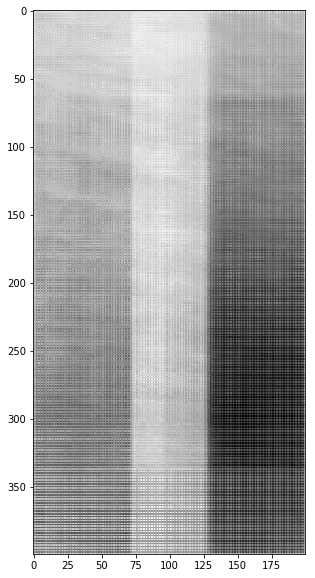

In [47]:
points = dls.process_pc(test_set["pc"][0:1], lambda x:x)[0]
res = get_prediction(model, points)
plot([[res[:, : ,0]]])

In [54]:
def threshold(res, threshold=0.9):
    '''
    Apply thresholding on probability values.
    '''
    _tmp = res.copy()
    _tmp[res >= threshold] = 255
    _tmp[res < threshold] = 0
    return _tmp.astype(np.uint8)

[[<matplotlib.axes._subplots.AxesSubplot at 0x7fac42baba20>]]

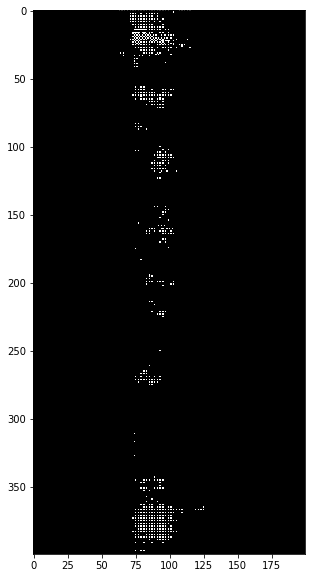

In [63]:
plot([[threshold(res, 0.5)[:, : ,0]]])

In [ ]:
# run the model on dataset
# plot img_gt, bev_points, road, nonroad, th_road, th_nonroad
# calculate metrics- F1 score, accuracy
# save it to the result dir

In [ ]:
#TODO: store it in Hdf5